#### ABOUT DATASET


The target variable represents the species of the iris flower and has three classes: Iris setosa, Iris versicolor, and Iris virginica.

- Iris setosa: Characterized by its relatively *small size*, with distinctive characteristics in sepal and petal dimensions.
- Iris versicolor: Moderate in size, with features falling between those of Iris setosa and Iris virginica.
- Iris virginica: Generally larger in size, with notable differences in sepal and petal dimensions compared to the other two species.

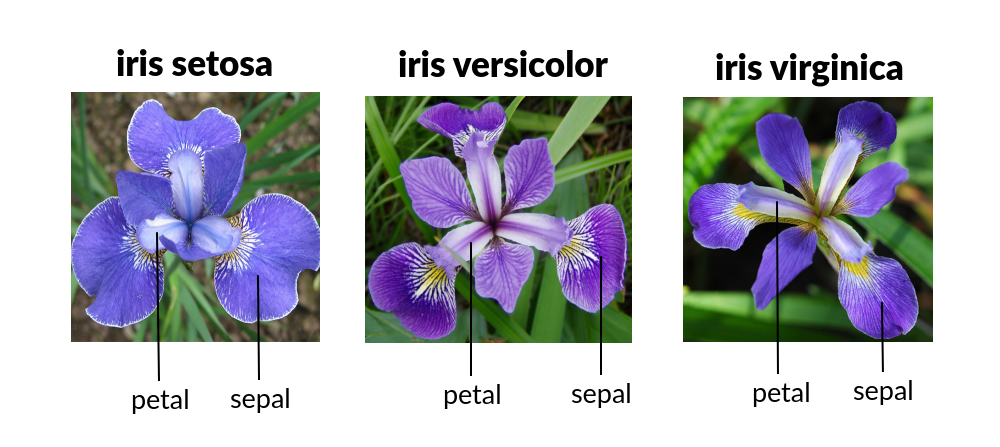

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
iris = sns.load_dataset("iris")

In [ ]:
iris.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [ ]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [ ]:
iris.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


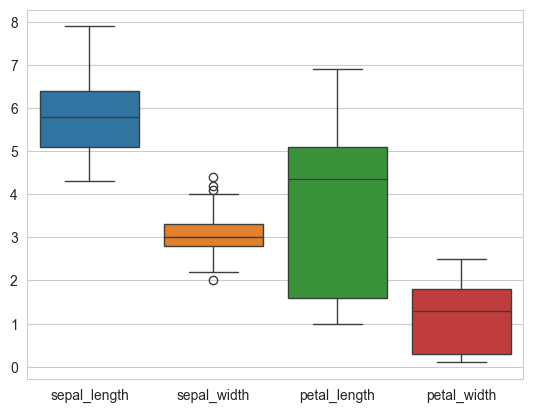

In [ ]:
sns.boxplot(iris)
plt.show()

From the box plot of Sepal Width, a few potential outliers are visible on both the lower and upper ends of the distribution.

Seems univariate anomalies, use IQR-based method? Or should i use more advanced approaches like Isolation Forest or One-Class SVM which uses row based information to detect outliers.

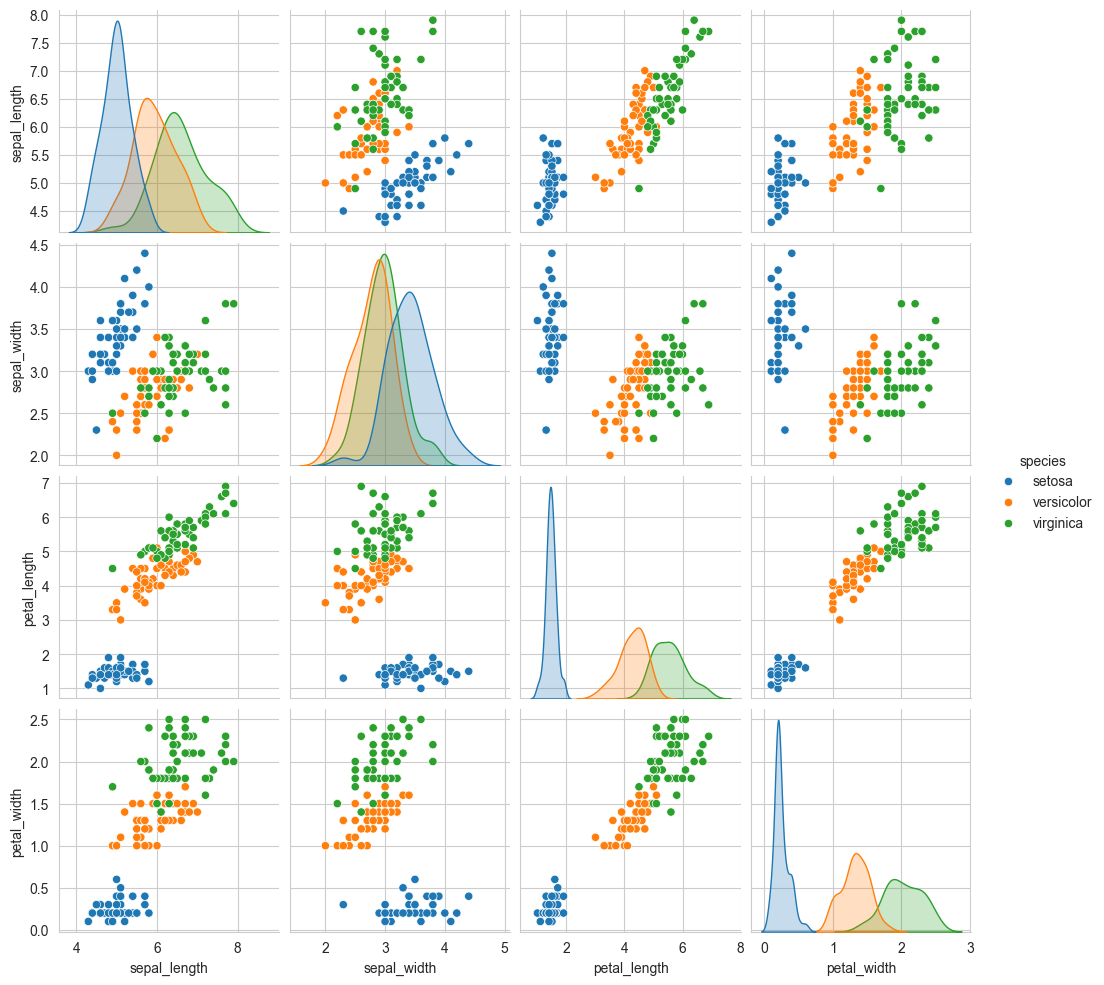

In [ ]:
sns.pairplot(iris, hue="species", kind="scatter")
plt.show()

- Petal measurements (especially petal length & width) are much more discriminative than sepal measurements.

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier

In [ ]:
X = iris.drop(columns=["species"])
y = iris["species"]

le = LabelEncoder()
y_encoded = le.fit_transform(y)

- Using feature selection to prove point

In [ ]:
sel = SequentialFeatureSelector(RandomForestClassifier())
sel.fit(iris.drop(columns=["species"]) , y_encoded)
sel.get_feature_names_out()

array(['petal_length', 'petal_width'], dtype=object)

Using t-SNE to project data to 2D

In [ ]:
tSNE = TSNE(n_components=2 , perplexity=30 , random_state=42)
X_tsne = tSNE.fit_transform(X)

In [ ]:
px.scatter(X_tsne, x=0, y=1, color=y)

- Setosa is linearly separable from the other two species.
- Versicolor and Virginica overlap and are harder to distinguish.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from mlxtend.plotting import plot_decision_regions
from sklearn.pipeline import Pipeline

Plotting decision boundary using ML

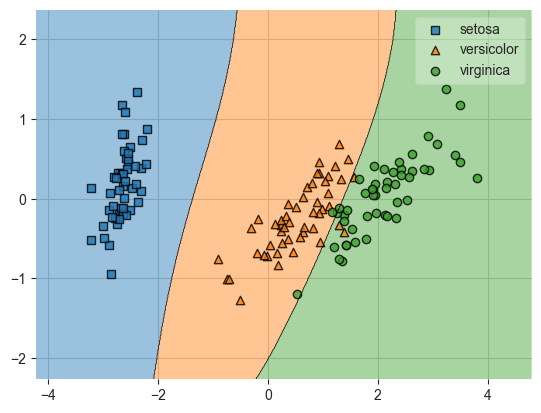

In [301]:
kpca = KernelPCA(n_components=2)
X_trans = kpca.fit_transform(X.to_numpy())

model = SVC(break_ties=True)
model.fit(X_trans, y_encoded)
plot_decision_regions(X_trans, y_encoded, model)

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, le.classes_, framealpha=0.3)
plt.show()

Finding best hyperparamaters & training the model

In [302]:
model_pipeline = Pipeline(
    [
        ("feature-extraction", KernelPCA(n_components=2 , kernel="rbf")),
        ("model-training", SVC(kernel="rbf", C=0.01, gamma="scale")),
    ]
)
model_pipeline

,steps,"[('feature-extraction', ...), ('model-training', ...)]"
,transform_input,None
,memory,None
,verbose,False
,n_components,2
,kernel,'rbf'
,gamma,None
,degree,3
,coef0,1
,kernel_params,None
,alpha,1.0


In [303]:
param_grid = {
    "feature-extraction__n_components": [2, 3, 4],
    "feature-extraction__kernel": ["linear", "poly", "rbf", "sigmoid"],
    "model-training__C": [0.01, 1, 10, 0.05, 0.5, 0.2, 0.3],
    "model-training__gamma": ["auto", "scale"],
    "model-training__break_ties": [True, False],
}
gcv = GridSearchCV(model_pipeline, param_grid, scoring="accuracy", cv=5, refit=True)
gcv.fit(X.to_numpy(), y_encoded)

print(gcv.best_estimator_)
print(gcv.best_score_)

Pipeline(steps=[('feature-extraction', KernelPCA(n_components=3)),
                ('model-training', SVC(C=1, break_ties=True, gamma='auto'))])
0.9800000000000001


In [304]:
clf = gcv.best_estimator_

Using classfier to predict

In [305]:
le.inverse_transform(clf.predict(X.iloc[[0]].to_numpy()))

array(['setosa'], dtype=object)